# Results and Issues
Covered in this notebook:
1. Obtain near-identical results to Ramirez's.
2. Highlight key issues impacting presented results.
    a.
    b.
    c.

In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import econtools.metrics as mt
import numpy as np
from econtools import read, outreg, table_statrow, write_notes
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('seaborn-v0_8-deep')

In [2]:
original_df = pd.read_csv(r'C:\Users\faxul\Google Drive\RamirezRepStudy\thesisminusdata\TradeCode\paper_repstudy\notFeelingTheBuzz\Datafiles\Ramirez_matches_cleaned.csv')
fitset = original_df[~(original_df['date'] > '2019-01-00')].copy()
testset = original_df[(original_df['date'] > '2019-01-00')].copy()

testset.reset_index(inplace=True)
print('Fit set rows: '+str(len(fitset)))
print('Test set rows: '+str(len(testset)))

Fit set rows: 15854
Test set rows: 5190


In [13]:
def fit_regression(rankdist: bool = True):
    if rankdist:
        results = mt.reg(
        fitset,                     # DataFrame
        'outcome',                      # Dependent var (string)
        ['inverse_avg', 'rankdist', 'wikibuzz'],# Independent var(s) (string or list of strings)
        cluster='match_id',
        addcons=True# Cluster var (string)
        )
        # Get params for use
        params = [results.beta[-1], results.beta[0], results.beta[1], results.beta[2]]
        #params= [constant        , inverse_avg    , rankdist       , wikibuzz       ]
        print(results)
    else:
        # No RankDist variable
        results = mt.reg(
            fitset,                     # DataFrame
            'outcome',                      # Dependent var (string)
            ['inverse_avg', 'wikibuzz'],# Independent var(s) (string or list of strings)
            cluster='match_id',
            addcons=True# Cluster var (string)
        )
        params = [results.beta[-1], results.beta[0], results.beta[1]]
        print(results)
    return params

def estimate_probability(params: pd.Series,
                         inverse_odds: float,
                         rankdist: float = None,
                         wikibuzz: float = None) -> float:
    if (rankdist is not None) & (wikibuzz is not None):
        y_hat = params[0] + params[-3]*inverse_odds + params[-2]*rankdist + params[-1]*wikibuzz
    if (rankdist is not None) & (wikibuzz is None):
        y_hat = params[0] + params[-2] * inverse_odds + params[-1] * rankdist
    if (wikibuzz is not None) & (rankdist is None):
        y_hat = params[0] + params[-2]*inverse_odds + params[-1]*wikibuzz
    return y_hat

def kelly_criterion(odds_implied_prob, y_hat):
    odds = 1/odds_implied_prob
    k = max(y_hat - ((1 - y_hat)/(odds - 1)), 0)
    return k

def profit_loss(kelly, odds_implied_prob, outcome):
    odds = 1 / odds_implied_prob
    if outcome == 1:
        PnL = kelly*odds - kelly
    if outcome == 0:
        PnL = -kelly
    return PnL

def show_results(testset, params, odds, rankdist: bool = True): # Odds = "avg", "best", "b365"

    # Estimate Probability.
    if rankdist:
        testset['model_est_prob'] = [estimate_probability(params, row[0], row[1], row[2]) for row in zip(testset['inverse_avg'],
                                                                                                         testset['rankdist'],
                                                                                                         testset['wikibuzz'])]
    else:
        testset['model_est_prob'] = [estimate_probability(params, inverse_odds=row[0], wikibuzz=row[1]) for row in zip(testset['inverse_avg'],
                                                                                                                       testset['wikibuzz'])]
    # Determine kelly bet size.
    testset['kelly_betsize'] = [kelly_criterion(row[0], row[1]) for row in zip(testset['inverse_{}'.format(odds)],
                                                                               testset['model_est_prob'])]
    # Calculate return for the bet.
    testset['PnL'] = [profit_loss(row[0], row[1], row[2]) for row in zip(testset['kelly_betsize'],
                                                                         testset['inverse_{}'.format(odds)],
                                                                         testset['outcome'])]

    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    print('Absolute return: '+str(testset['PnL'].sum()))
    print('Absolute amount bet: '+str(testset['kelly_betsize'].sum()))
    print('ROI (%): '+str((((testset['PnL'].sum() + testset['kelly_betsize'].sum())/testset['kelly_betsize'].sum())-1)*100))

def plot_results():
    testset['Cum_PnL'] = testset['PnL'].cumsum() * 100
    plt.rcParams.update({'font.size': 11})
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    testset.plot('date', 'Cum_PnL', ax=ax, linewidth=1.5)
    ax.set_ylabel('Cumulative Profit (%)')
    ax.set_xlabel('Date')
    ax.set_title("")
    # ax.set_title('Best Odds')
    ax.get_legend().remove()
    fig.autofmt_xdate()
    plt.show()

# Bet365 Models

In [14]:
params = fit_regression(rankdist=True)
show_results(testset, params=params, odds="b365", rankdist=True)

Dependent variable:	outcome
N:			15854
R-squared:		0.1589
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.025 0.028 36.945 0.000  0.971   1.080
rankdist     0.055 0.031  1.787 0.074 -0.005   0.115
wikibuzz     0.009 0.004  2.117 0.034  0.001   0.017
_cons       -0.041 0.015 -2.831 0.005 -0.070  -0.013

Bets considered (2 * Matches): 5156
Number of bets placed: 312
Absolute return: 1.2360930817859561
Absolute amount bet: 7.151004389194103
ROI (%): 17.285586954104225


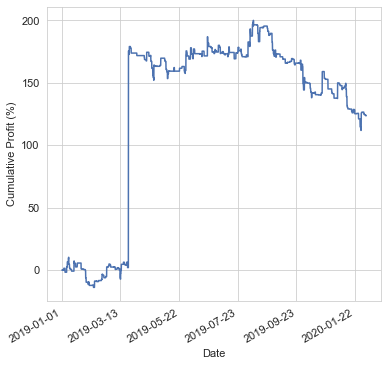

In [15]:
plot_results()

In [16]:
params = fit_regression(rankdist=False)
show_results(testset, params=params, odds="b365", rankdist=False)

Dependent variable:	outcome
N:			15854
R-squared:		0.1586
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  7927
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.005 0.025 39.826 0.000  0.956   1.055
wikibuzz     0.010 0.004  2.265 0.024  0.001   0.018
_cons       -0.031 0.013 -2.323 0.020 -0.057  -0.005

Bets considered (2 * Matches): 5156
Number of bets placed: 276
Absolute return: 1.4372911056209992
Absolute amount bet: 4.987843280940591
ROI (%): 28.81588343228698


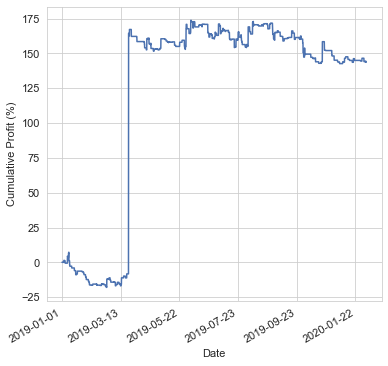

In [17]:
plot_results()

In [21]:
testset.sort_values(by=["PnL"], ascending=False).head()

,index,Unnamed: 0,match_id,player,date,year,rankdist,wikibuzz,inverse_b365,inverse_avg,inverse_best,outcome,model_est_prob,kelly_betsize,PnL,Cum_PnL
1135,16989,5883,5883,Hercog P.,2019-03-23,2019.0,-0.001824,-1.707411,0.181818,0.540541,0.476190,1,0.495942,0.383929,1.727679,164.467343
4439,20293,20000,20000,Kudermetova V.,2019-10-17,2019.0,0.226190,1.707976,0.307692,0.364964,0.307692,1,0.352341,0.064492,0.145107,158.468550
3174,19028,15940,15940,Di Lorenzo F.,2019-08-05,2019.0,0.041040,3.427324,0.230947,0.259740,0.222222,1,0.263127,0.041844,0.139341,169.087928
2115,17969,10071,10071,Bolsova A.,2019-05-27,2019.0,0.005521,4.553877,0.500000,0.546448,0.487805,1,0.562174,0.124348,0.124348,167.387581
3249,19103,15975,15975,Andreescu B.,2019-08-08,2019.0,0.162963,3.861998,0.333333,0.353357,0.319489,1,0.361416,0.042125,0.084249,172.400442
